In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split, cross_val_score, KFold)
from sklearn.linear_model import (LinearRegression, Lasso)
import statsmodels.api as sm
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('baseball_data.xlsx')
# Please see "Web Scraping - Baseball Seasonal Records.ipynb" for details on this file's creation

In [4]:
df.head()

,Year,Old Team,Team,Wins,Losses,Win-Loss_%,Total_Batting_Salary,Total_Pitching_Salary,Total_Team_Salary,Inflation Adjustment,...,Average_Weight_of_Pitcher,Average_Height_of_Batter,Average_Weight_of_Batter,Average_Team_Age,Average_Years_Play,Average_Team_Height,Average_Team_Weight,Batting_URL,Pitching_URL,Roster_URL
0,1980,ATL,ATL,81,80,1.012500,2071667,1706667.0,1.950000e+06,3.14,...,189.090909,72.285714,180.809524,27.733333,6.325758,72.688312,184.950216,https://www.baseball-reference.com/teams/ATL/1...,https://www.baseball-reference.com/teams/ATL/1...,https://www.baseball-reference.com/teams/ATL/1...
1,1980,CHC,CHC,64,98,0.653061,975000,700000.0,8.833333e+05,3.14,...,197.916667,72.590909,185.000000,28.600000,5.516340,73.712121,191.458333,https://www.baseball-reference.com/teams/CHC/1...,https://www.baseball-reference.com/teams/CHC/1...,https://www.baseball-reference.com/teams/CHC/1...
2,1980,KCR,KCR,97,65,1.492308,825000,685000.0,7.783333e+05,3.14,...,190.666667,71.818182,180.636364,28.266667,6.087087,73.042424,185.651515,https://www.baseball-reference.com/teams/KCR/1...,https://www.baseball-reference.com/teams/KCR/1...,https://www.baseball-reference.com/teams/KCR/1...
3,1980,NYY,NYY,103,59,1.745763,4248458,2013458.0,3.503458e+06,3.14,...,188.923077,71.692308,178.000000,30.400000,9.068376,73.000000,183.461538,https://www.baseball-reference.com/teams/NYY/1...,https://www.baseball-reference.com/teams/NYY/1...,https://www.baseball-reference.com/teams/NYY/1...
4,1980,SDP,SDP,73,89,0.820225,1641667,1031667.0,1.438334e+06,3.14,...,188.400000,71.904762,182.380952,28.200000,6.033333,73.119048,185.390476,https://www.baseball-reference.com/teams/SDP/1...,https://www.baseball-reference.com/teams/SDP/1...,https://www.baseball-reference.com/teams/SDP/1...


In [5]:
#sns.heatmap(df.corr(),cmap='seismic',annot=True, vmin=-1,vmax=1)

- In order to explore as many feature combinations as possible, the dataframe will be split into smaller dataframes with total, batting-only, and pitching-only values respectively. 
- Wins & losses will be dropped in favor of the win-loss percentage.
- Adjusted salaries for inflation matching up to 2020 are used.

In [6]:
total_df = df[["Year",
"Team",
"Win-Loss_%",
"Total_Adj_Team_Salary",
"Average_Team_Age",
"Average_Years_Play",
"Average_Team_Height",
"Average_Team_Weight"]]

In [7]:
batting_df = df[["Year",
"Team",
"Win-Loss_%",
"Total_Adj_Batting_Salary",
"Average_Batting_Age",
"Average_Years_Batting",
"Average_Height_of_Batter",
"Average_Weight_of_Batter"]]

In [8]:
pitching_df =df[["Year",
"Team",
"Win-Loss_%",
"Total_Adj_Pitching_Salary",
"Average_Pitching_Age",
"Average_Years_Pitching",
"Average_Height_of_Pitcher",
"Average_Weight_of_Pitcher",]]

In [9]:
#sns.pairplot(pitching_df.drop(columns=["Year"]), plot_kws=dict(alpha=.10))

In [10]:
#sns.pairplot(batting_df.drop(columns=["Year"]), plot_kws=dict(alpha=.10))

###### Quick visual sense of total_df:

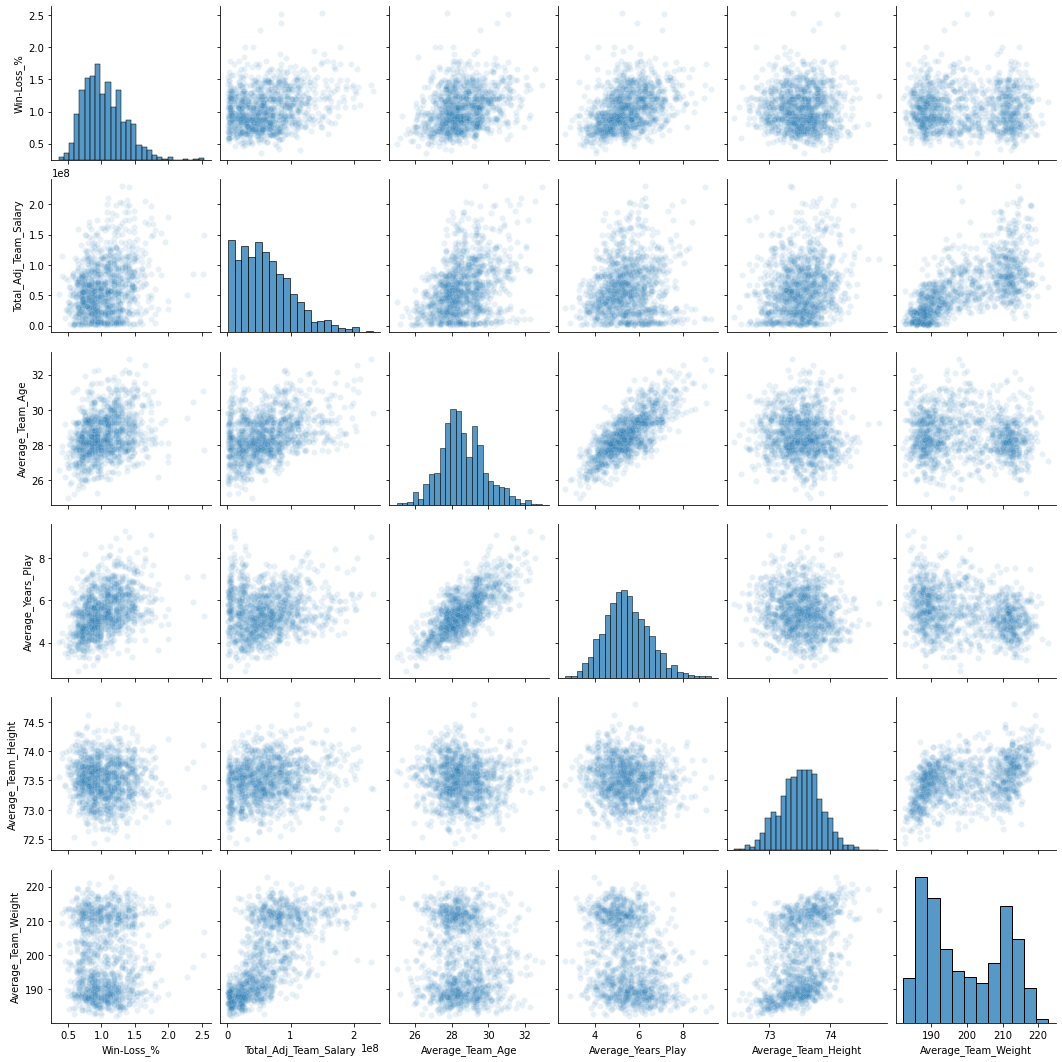

In [11]:
sns.pairplot(total_df.drop(columns=["Year"]), plot_kws=dict(alpha=.10))

###### Below is a close look at salary that also helps us visualize individual teams

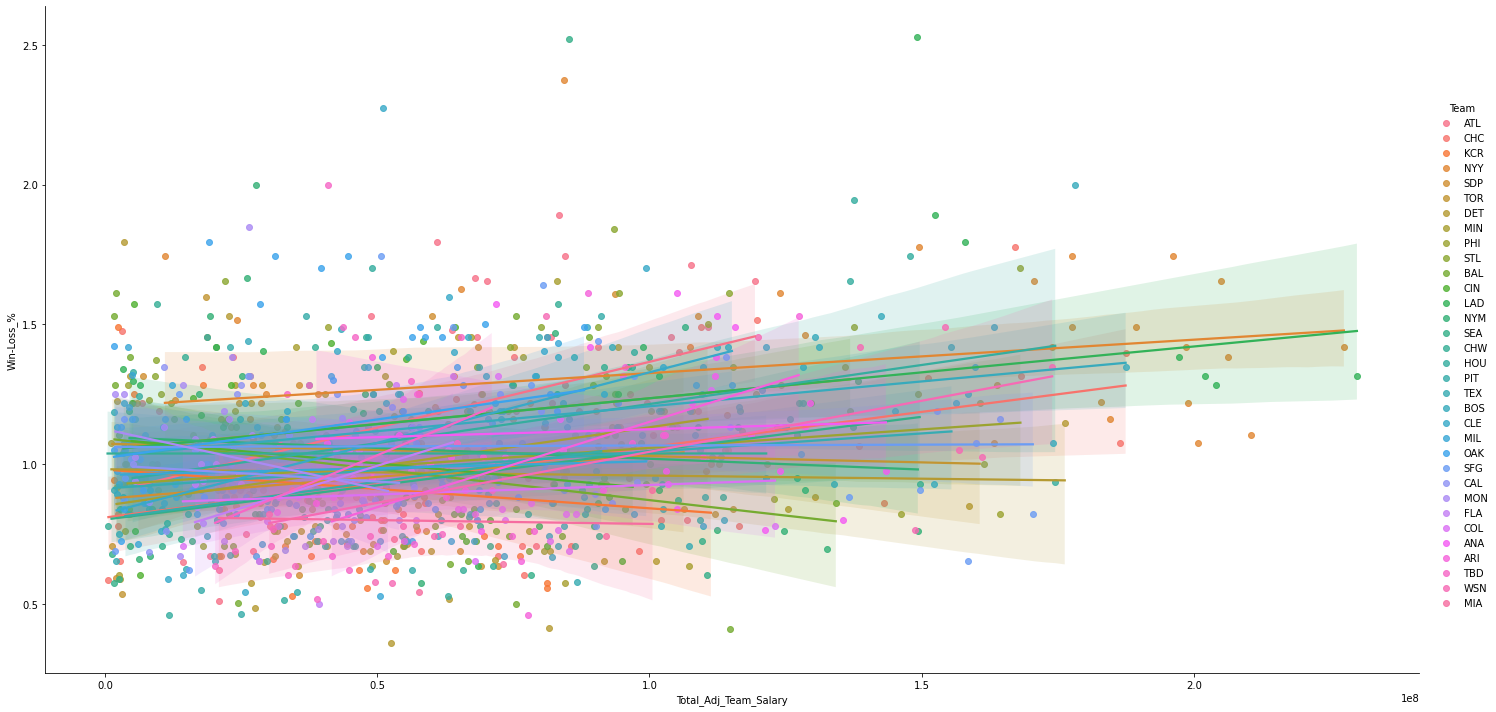

In [47]:
sns.lmplot(x="Total_Adj_Team_Salary",
           y="Win-Loss_%",
           hue="Team",
           data=total_df,
           height = 10,aspect=2)

- Certain obvious relationships are visible from the pairplot, most notably between age & years of experience (see correlation table below as well). 
- These two also happen to be the most correlated to wins & losses, our target. 
- Their obvious multicollinearity and the OLS results below indicate that one or the other should be selected.

In [12]:
total_df.drop(columns=["Year"]).corr()

,Win-Loss_%,Total_Adj_Team_Salary,Average_Team_Age,Average_Years_Play,Average_Team_Height,Average_Team_Weight
Win-Loss_%,1.000000,0.252794,0.303471,0.397420,-0.014924,0.004146
Total_Adj_Team_Salary,0.252794,1.000000,0.367769,0.119643,0.194644,0.671255
Average_Team_Age,0.303471,0.367769,1.000000,0.762941,-0.057221,-0.084070
Average_Years_Play,0.397420,0.119643,0.762941,1.000000,-0.126869,-0.297067
Average_Team_Height,-0.014924,0.194644,-0.057221,-0.126869,1.000000,0.422037
Average_Team_Weight,0.004146,0.671255,-0.084070,-0.297067,0.422037,1.000000


In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = total_df.select_dtypes(include=numerics)
x = new_df.drop(columns=["Win-Loss_%","Year"])
y = df["Win-Loss_%"]

In [14]:
x = sm.add_constant(x)
model = sm.OLS(y,x)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Win-Loss_%   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     63.05
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           2.85e-58
Time:                        00:22:51   Log-Likelihood:                -112.87
No. Observations:                1168   AIC:                             237.7
Df Residuals:                    1162   BIC:                             268.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.2641      1.810      0.698      0.485      -2.287       4.815
Total_Adj_Team_Salary  2.249e-09   3.01e-10      7.475      0.000    1.66e-09    2.84e-09
Average_Team_Age         -0.0454      0.011     -4.055      0.000      -0.067      -0.023
Average_Years_Play        0.1401      0.013     10.929      0.000       0.115       0.165
Average_Team_Height       0.0094      0.025      0.368      0.713      -0.041       0.059
Average_Team_Weight      -0.0026      0.001     -2.081      0.038      -0.005      -0.000
==============================================================================
Omnibus:                      153.898   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.532
Skew:                           0.837   Prob(JB):                     2.43e-60
Kurtosis:                       4.684   Cond. No.                     1.74e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###### Here we remove age in favor of experience. Unfortunately, the r values get even lower:

In [15]:
total_df.drop(columns=["Year","Average_Team_Age"]).corr()

,Win-Loss_%,Total_Adj_Team_Salary,Average_Years_Play,Average_Team_Height,Average_Team_Weight
Win-Loss_%,1.000000,0.252794,0.397420,-0.014924,0.004146
Total_Adj_Team_Salary,0.252794,1.000000,0.119643,0.194644,0.671255
Average_Years_Play,0.397420,0.119643,1.000000,-0.126869,-0.297067
Average_Team_Height,-0.014924,0.194644,-0.126869,1.000000,0.422037
Average_Team_Weight,0.004146,0.671255,-0.297067,0.422037,1.000000


In [16]:
slim_x = x.drop(columns=["Average_Team_Age"])
slim_x = sm.add_constant(slim_x)
model_2 = sm.OLS(y,slim_x)
fit_2 = model_2.fit()
fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Win-Loss_%   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     73.72
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           1.01e-55
Time:                        00:22:53   Log-Likelihood:                -121.07
No. Observations:                1168   AIC:                             252.1
Df Residuals:                    1163   BIC:                             277.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2368      1.804      0.131      0.896      -3.302       3.776
Total_Adj_Team_Salary  1.763e-09   2.78e-10      6.347      0.000    1.22e-09    2.31e-09
Average_Years_Play        0.1034      0.009     11.313      0.000       0.085       0.121
Average_Team_Height       0.0068      0.026      0.265      0.791      -0.043       0.057
Average_Team_Weight      -0.0018      0.001     -1.487      0.137      -0.004       0.001
==============================================================================
Omnibus:                      157.341   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.239
Skew:                           0.860   Prob(JB):                     1.04e-60
Kurtosis:                       4.649   Cond. No.                     1.72e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###### Since the second round of R values was weaker, the first model is better, though still not robust. We will attempt some standardization after using train_test_split:

In [65]:
#Creating training and test sets
salary = total_df["Total_Adj_Team_Salary"]
target = total_df["Win-Loss_%"]
sal, sal_test, y, y_test = train_test_split(salary,target, 
              test_size=.3,     
              random_state=42)

In [18]:
sal = np.expand_dims(sal,axis=1)

In [19]:
lr_model1_lasso = Lasso(alpha = 5)

In [20]:
lr_model1_lasso.fit(sal,y)

Lasso(alpha=5)

In [21]:
print(list(zip(sal,lr_model1_lasso.coef_)))

[(array([95114213.14666662]), 1.731851758075773e-09)]


In [22]:
lasso_r = lr_model1_lasso.score(sal,y)

In [23]:
print(lasso_r)

0.06328188504576726


###### This R score indicates the model is good for about 6% of the data, whereas the others were about 20%.
- A new linear regression model will be created for the test subset.
- The residuals will be plotted.

In [24]:
model2 = sm.OLS(y,sal)
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Win-Loss_%   R-squared (uncentered):                   0.686
Model:                            OLS   Adj. R-squared (uncentered):              0.685
Method:                 Least Squares   F-statistic:                              1780.
Date:                Wed, 23 Feb 2022   Prob (F-statistic):                   2.94e-207
Time:                        00:23:02   Log-Likelihood:                         -748.16
No. Observations:                 817   AIC:                                      1498.
Df Residuals:                     816   BIC:                                      1503.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.176e-08   2.79e-10     42.189      0.000    1.12e-08    1.23e-08
==============================================================================
Omnibus:                        9.283   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.276
Skew:                          -0.257   Prob(JB):                      0.00968
Kurtosis:                       3.087   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
y_pred = fit2.predict(sal)

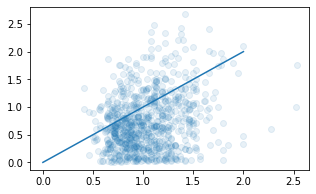

In [26]:
plt.figure(figsize=(5,3))
plt.scatter(y,y_pred,alpha=0.1)
plt.plot([0,2],[0,2])

###### The residuals are fan-shaped; perhaps a polynomial regression would be a better fit.

/Users/francescaepiccorelli/opt/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


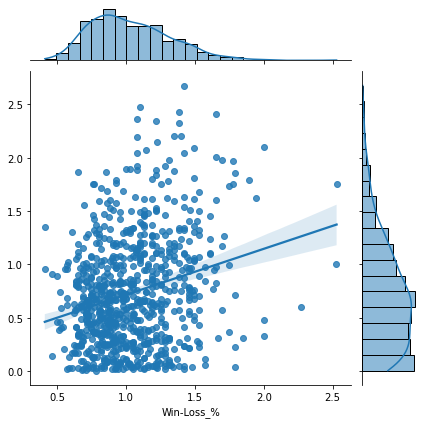

In [27]:
sns.jointplot(y,y_pred,kind='reg')

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [45]:
def plot_approximation(est, ax, label=None):
    ax.plot(sal, y, label='ground truth', color='green')
    ax.scatter(sal, y, s=100)
    ax.plot(sal, est.predict(sal[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

In [52]:
new_sal.shape

NameError: name 'new_sal' is not defined

ValueError: Found array with dim 3. Estimator expected <= 2.

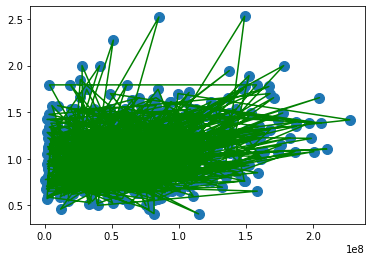

In [66]:
fig,ax = plt.subplots(1,1)
degree = 3
est = make_pipeline(PolynomialFeatures(3), LinearRegression())
sal = np.expand_dims(sal,axis=1)
new_sal = sal.reshape((-1,1))
#nx, ny = sal.shape
#new_sal = sal.reshape((ny&nx))
#new_sal = np.expand_dims(sal,axis=1)
poly_model = est.fit(new_sal, y)
plot_approximation(poly_model, ax, label='degree=%d' % degree)

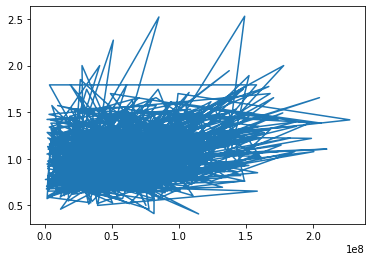

In [44]:
plt.plot(sal,y)